# __INFERENCE SEPP__

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import utils

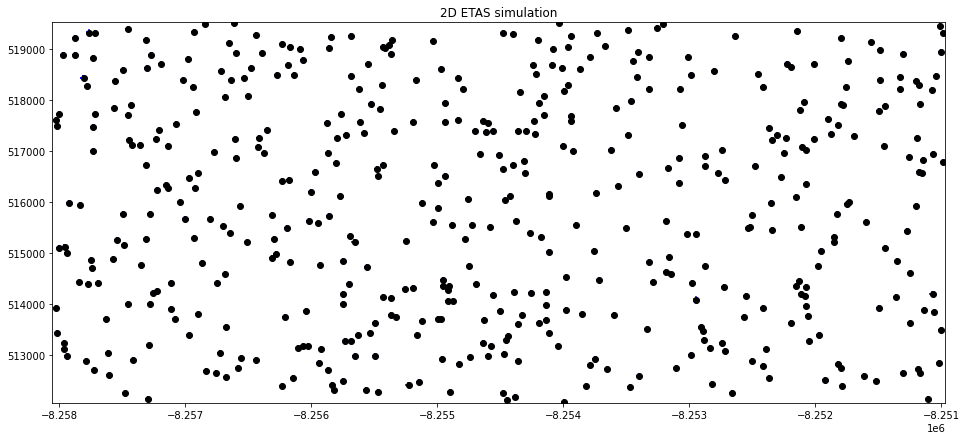

In [146]:
from collections import namedtuple
Event = namedtuple("Event", ["t", "locx", "locy"])

mu = np.exp(-0.432229 * 1 - 0.012163 * 0.75)
alpha = 0.3
sigma = np.sqrt(0.208075)
omega = 9.351865


# ALMACENA TIEMPOS GENERADOS A TRAVES DE UNA DISTRIBUCIÓN EXPONENCIAL (TIEMPOS ENTRE-LLEGADAS) 
# DE TAL FORMA QUE OBTENEMOS UN CONJUNTO DE TIEMPOS DE LLEGADA 
def _add_point(points, scale=2.0):
    wait_time = np.random.exponential(scale)
    if len(points) == 0:
        last = 0
    else:
        last = points[-1]
    points.append(last + wait_time)

# AGREGAMOS LOS TIEMPOS A UN ARREGLO DESDE QUE SEAN MENOR QUE LA VENTANA TEMPORAL DEL PROCESO     
def sample_poisson_process(window_size=744, scale=1/mu):
    points = []
    _add_point(points, scale)
    while points[-1] < window_size:
        _add_point(points, scale)
    return points  


def sort_with_causes(points, caused_by):
    """Sorts `points` in time order, and maintains caused by information"""
    # caused_by[i] = j<i if i caused by j, or i if i background
    tagged = list(enumerate(points))
    tagged.sort(key = lambda pair : pair[1].t)
    new_caused_by = []
    for old_index, event in tagged:
        old_cause_index = caused_by[old_index]
        new_cause_index,_ = next(x for x in enumerate(tagged) if x[1][0] == old_cause_index)
        new_caused_by.append(new_cause_index)
    events = [x[1] for x in tagged]
    return events, new_caused_by

# SIMULA EL PROCESO DE CREACION DE LOS EVENTOS DESCENDENTES DE LOS EVENTOS DEL BACKGROUND
def simulate_sub_process(parent : Event):
    points = []
    t = 0
    while True:
        t += np.random.exponential()
        if t >= alpha:
            return points
        locx = np.random.normal(loc=parent.locx, scale=sigma)
        locy = np.random.normal(loc=parent.locy, scale=sigma)
        points.append(Event(parent.t + t / (alpha - t), locx, locy))

# SIMULA TODO EL PROCESO DE HAWKES ESPACIO-TEMPORAL (0,T] X R2        
def simulate(window_size=744):
    
    # CREAMOS LOS EVENTOS DEL BACKGROUND
    backgrounds = sample_poisson_process(window_size, 1/mu)
    
    # ALMACENAMOS EN LA FORMA DE "Event = Event(t, x, v)"
    backgrounds = [Event(t, np.random.uniform(-8258052, -8250968), np.random.uniform(512068,519525)) for t in backgrounds]
    
    # ALMACEMOS EN points
    points = list(backgrounds)
    
    # CREAMOS EL ARREGLOS PARA INDICAR QUIEN CAUSO LOS DESCENDIENTES
    caused_by = [ i for i in range(len(points)) ]
    
    # ENUMERAMOS EN LA FORMA [(0, Evento_background(t, loc))]
    to_process = [(i,p) for i, p in enumerate(points)]
    
    while len(to_process) > 0:
        
        # EXTRAE EL NUMERO DEL EVENTO (INDEX) Y EL EVENTO(NEXT_POINT) DEL ULTIMO EVENTO
        # Y LO ELIMINA DE LA LISTA. EES DECIR, EXTRAE EL ULTIMO EVENTO DEL BACKGROUND DE LA 
        # LISTA DE EVENTOS
        (index, next_point) = to_process.pop()
        
        # PARA CADA EVENTO DEL ULTIMO EVENTO DEL BACKGROUND DE LA LISTA to_process
        for event in simulate_sub_process(next_point):
        
            # SI EL TIEMPO DE CADA DESCENDIENTE < VENTANA TEMPORAL
            if event.t < window_size:
                
                # ALMACENAMOS EL EVENTO DESCENDIENTE EN EL ARREGLO points, EL CUAL ESTA
                # ALMACENANDO INICIALMENTE LOS EVENTOS DEL BACKGROUND
                points.append(event)
                
                # ALMACENAMOS EL INDICE DEL EVENTO DEL BACKGROUND (INDEX) EL CUAL HA GENERADO
                # EL CUAL HA GENERADO EL RESPECTIVO EVENTO DESCENDIENTE
                caused_by.append(index)                
                
                #ALMACENAMOS LOS EVENTOS DESCENDIENTES CON EL INDICE (INDEX) DADO POR LA
                # LONGITUD DEL ARREGLO len(points-1) Y EL RESPECTIVO EVENTO DESCENDIENTE
                to_process.append((len(points) - 1,event))
    
    # ORDENAMOS LOS ARREGLOS to_proccess Y caused_by PARA TENERLOS EN ORDEN TEMPORAL
    points, caused_by = sort_with_causes(points, caused_by)
    return points, backgrounds, caused_by


points, backgrounds, caused_by = simulate()
width, _ = utils.slim_aspect()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(width,7))
ax.set(xlim=[-8258052, -8250968], ylim=[512068,519525], title="2D ETAS simulation")
_ = ax.scatter(x=[e.locx for e in points], y=[e.locy for e in points], color="blue", marker="+")
_ = ax.scatter(x=[e.locx for e in backgrounds], y=[e.locy for e in backgrounds], color="black")

# __Model Extraction__

In [117]:
# VALOR DE MU 
def mu_func(t, x, y, mu):
    return  mu #* np.random.uniform()  #  np.exp(beta1*1 + beta2 * 0.75)

# VALOR DEL KERNEL
def g_func(dt, dx, dy, omega, alpha, sigma):
    kernel = np.exp(-0.5 * (dx/sigma)**2 - 0.5 * (dy/sigma)**2)* np.exp(-dt/omega)/(2 * np.pi * sigma*sigma * omega) 
    return kernel

In [118]:
def make_probability_matrix(points, mu, alpha, sigma):
    p_matrix = np.zeros((len(points), len(points)))
    for i, point in enumerate(points):
        p_matrix[i][i] = mu_func(point.t, point.locx, point.locy, mu)
        for j in range(i):
            j_point = points[j]
            p_matrix[j][i] = g_func(point.t - j_point.t, point.locx - j_point.locx, point.locx - j_point.locx, omega, alpha, sigma)

    column_sums = np.sum(p_matrix, axis=0)
    p_matrix /= column_sums
    return p_matrix

In [119]:
p_matrix = make_probability_matrix(points, mu, alpha, sigma)
percentage_array = (p_matrix*100+0.5).astype(int)
max_index = [ np.argmax(percentage_array[:,i]) for i in range(len(points)) ]

background_points, triggered_points = [], []
for i, p in enumerate(points):
    if max_index[i] == i:
        background_points.append(p)
    else:
        triggered_points.append(p)

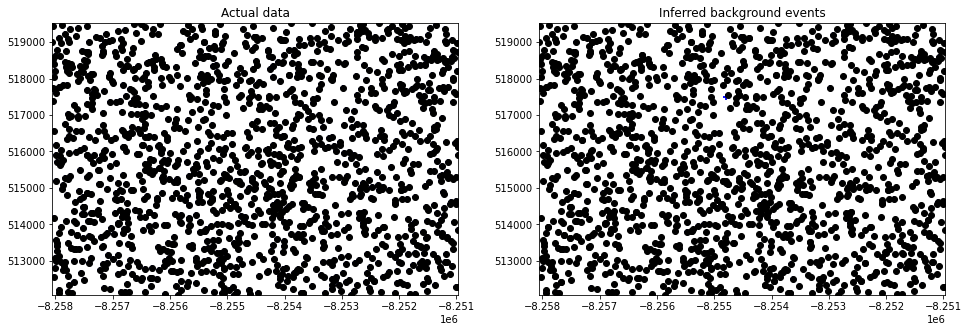

In [120]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(width,5))

ax[0].set(xlim=[-8258052, -8250968], ylim=[512068,519525], title="Actual data")
_ = ax[0].scatter(x=[e.locx for e in points], y=[e.locy for e in points], color="blue", marker="+")
_ = ax[0].scatter(x=[e.locx for e in backgrounds], y=[e.locy for e in backgrounds], color="black", marker="o")

ax[1].set(xlim=[-8258052, -8250968], ylim=[512068,519525], title="Inferred background events")
_ = ax[1].scatter(x=[e.locx for e in triggered_points], y=[e.locy for e in triggered_points], color="blue", marker="+")
_ = ax[1].scatter(x=[e.locx for e in background_points], y=[e.locy for e in background_points], color="black", marker="o")

# __Iterative approximation for parametric distributions__

In [179]:
# MATRIZ DE PROBABILIDADES
def sample_causality(p_matrix):
    """Returns a list where entry i is the j<i which caused i, or i if i is background"""
    number_points = p_matrix.shape[0]
    causes = np.empty(number_points, dtype=int)
    for i in range(number_points):
        choices = list(range(i+1))
        probs = p_matrix[:i+1, i]
        c = np.random.choice(choices, p=probs)
        causes[i] = c
    return causes


def compute_backgrounds_deltas(causes, points):
    backgrounds, trigger_deltas = [], []
    causes = sample_causality(p_matrix)
    for i, p in enumerate(points):
        c = causes[i]
        if c == i:
            backgrounds.append(p)
        else:
            tp = points[c]
            delta = Event(p.t - tp.t, p.locx - tp.locx, p.locy - tp.locy)
            trigger_deltas.append(delta)
    return backgrounds, trigger_deltas

def make_estimates(causes, points):
    """Returns MLEs for mu, alpha and sigma."""
    backgrounds, trigger_deltas = compute_backgrounds_deltas(causes, points)
    #background_event_times = np.array([e.t for e in backgrounds])
    #background_event_time_deltas = background_event_times[1:] - background_event_times[:-1]
    #mu = 1 / np.mean(background_event_time_deltas)
    window_size = 744
    mu = len(backgrounds) / window_size
    
    space_points = [e.locx for e in trigger_deltas]
    sigma = np.std(space_points, ddof=1)
    
    # Biased...
    counts = np.empty(len(causes) - 1, dtype=np.int32)
    for i in range(len(causes) - 1):
        counts[i] = sum(c==i for c in causes[i+1:])
    alpha = np.mean(counts)
    
    return mu, alpha, sigma

In [180]:
p_matrix = make_probability_matrix(points, mu, alpha, sigma)
mu_e, alpha_e, sigma_e = make_estimates(caused_by, points)
mu_e, alpha_e, sigma_e

(0.9260752688172043, 0.30823863636363635, 0.27240594613708186)

In [181]:
p_matrix = make_probability_matrix(points, mu, alpha, sigma)
causes = sample_causality(p_matrix)
mu_e, alpha_e, sigma_e = make_estimates(causes, points)
mu_e, alpha_e, sigma_e

(0.9220430107526881, 0.02130681818181818, 0.31442684371804214)

In [182]:
p_matrix

array([[1.00000000e+00, 7.51802446e-02, 5.15818600e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 9.24819755e-01, 3.36473271e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 9.94505341e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.97163767e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [183]:
mu_e, alpha_e, sigma_e = 1, 2, 0.5

for _ in range(20):
    p_matrix = make_probability_matrix(points, mu_e, alpha_e, sigma_e)
    causes = sample_causality(p_matrix)
    mu_e, alpha_e, sigma_e = make_estimates(causes, points)

mu_e, alpha_e, sigma_e

(0.9193548387096774, 0.03409090909090909, 0.026933445338294913)

[0 0 0 ... 0 0 0]


In [75]:
%matplotlib inline
import math
import numpy as np
import random as rd
from random import randint
from scipy.optimize import fsolve
import scipy.optimize as optimize
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import timeit
import datetime
import matplotlib.pyplot as plt

e = math.e
pi = math.pi

data = pd.read_csv('union_dataframes.csv')
data = data[(data['FECHA'] >= '2018-01-01 00:00:00') & (data['FECHA'] <= '2018-01-31 23:59:59')]
data['TimeStamp'] = ' '
for i in range(0, len(data)):
    data.TimeStamp.iloc[i] = datetime.datetime.fromisoformat(str(data.FECHA.iloc[i])).timestamp()
data['geometry'] = data['geometry'].apply(wkt.loads)
data.TimeStamp = (data.TimeStamp-data.TimeStamp.iloc[0])/3600+0.0001
data = gpd.GeoDataFrame(data, geometry = 'geometry')
data = data.rename(columns={'LONGITUD': 'Long', 'LATITUD': 'Lat'})
data.cov1 = (data.cov1-data.cov1.min())/(data.cov1.max()-data.cov1.min())
data.cov2 = (data.cov2-data.cov2.min())/(data.cov2.max()-data.cov2.min())


In [83]:
data['geometry'].y.min()

512069.0722915839

In [80]:
len(points)

225

In [107]:
number_points = p_matrix.shape[0]

1717

In [166]:
number_points = p_matrix.shape[0]
causes = np.empty(number_points, dtype=int)

In [167]:
causes

array([                   0,                   33,                    0,
       ...,      140544153998512,           4321024320,
       -2222480559271096373])

In [165]:
np.empty(number_points, dtype=int)

array([                 0,                 33,                  0, ...,
       688704416848855238,    140544153997616,    140544152058992])